In [1]:
import pandas as pd

# Load the dataset
file_path = 'kamrup_rice_cleaned_data.csv'
rice_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
rice_data.head(), rice_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Year                    23 non-null     object 
 1   Yield (Tonnes/Hectare)  23 non-null     float64
dtypes: float64(1), object(1)
memory usage: 496.0+ bytes


(         Year  Yield (Tonnes/Hectare)
 0  1997-01-01                0.980326
 1  1998-01-01                1.295593
 2  1999-01-01                1.419327
 3  2000-01-01                1.505253
 4  2001-01-01                1.536712,
 None)

In [2]:
# Data Preprocessing

# Convert the "Year" column to datetime format
rice_data['Year'] = pd.to_datetime(rice_data['Year'])

# Set the "Year" column as the index
rice_data.set_index('Year', inplace=True)

# Normalize the yield data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
rice_data['Yield (Tonnes/Hectare)'] = scaler.fit_transform(rice_data[['Yield (Tonnes/Hectare)']])

# Display the first few rows of the preprocessed data
rice_data.head()


,Yield (Tonnes/Hectare)
Year,
1997-01-01,0.000000
1998-01-01,0.189116
1999-01-01,0.263338
2000-01-01,0.314881
2001-01-01,0.333752


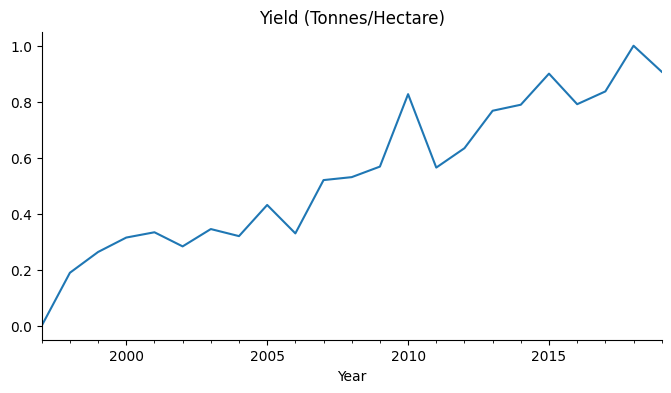

In [13]:
# @title Yield (Tonnes/Hectare)

from matplotlib import pyplot as plt
rice_data['Yield (Tonnes/Hectare)'].plot(kind='line', figsize=(8, 4), title='Yield (Tonnes/Hectare)')
plt.gca().spines[['top', 'right']].set_visible(False)

In [3]:
import numpy as np

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
seq_length = 3

# Convert the dataframe to a numpy array
data = rice_data['Yield (Tonnes/Hectare)'].values

# Create sequences
X, y = create_sequences(data, seq_length)

# Split the data into training and testing sets (70% train, 30% test)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((16, 3), (4, 3), (16,), (4,))

In [4]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Reshape the data to fit the model's input shape
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=200, validation_data=(X_test_reshaped, y_test), verbose=1)

# Summarize the model
model.summary()


Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.3166 - val_loss: 0.7678
Epoch 2/200
1/1 [==============================] - 0s 51ms/step - loss: 0.3110 - val_loss: 0.7557
Epoch 3/200
1/1 [==============================] - 0s 47ms/step - loss: 0.3056 - val_loss: 0.7437
Epoch 4/200
1/1 [==============================] - 0s 68ms/step - loss: 0.3001 - val_loss: 0.7318
Epoch 5/200
1/1 [==============================] - 0s 52ms/step - loss: 0.2947 - val_loss: 0.7199
Epoch 6/200
1/1 [==============================] - 0s 44ms/step - loss: 0.2894 - val_loss: 0.7081
Epoch 7/200
1/1 [==============================] - 0s 46ms/step - loss: 0.2841 - val_loss: 0.6963
Epoch 8/200
1/1 [==============================] - 0s 43ms/step - loss: 0.2789 - val_loss: 0.6847
Epoch 9/200
1/1 [==============================] - 0s 43ms/step - loss: 0.2738 - val_loss: 0.6733
Epoch 10/200
1/1 [==============================] - 0s 39ms/step - loss: 0.2688 - val_loss: 0.6621
Epoch 11/200
1/1 [===

In [5]:
y_pred = model.predict(X_test_reshaped)

1/1 [==============================] - 0s 366ms/step


In [6]:
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))


In [7]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.024638626313890973


In [8]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 0.14285730884246828


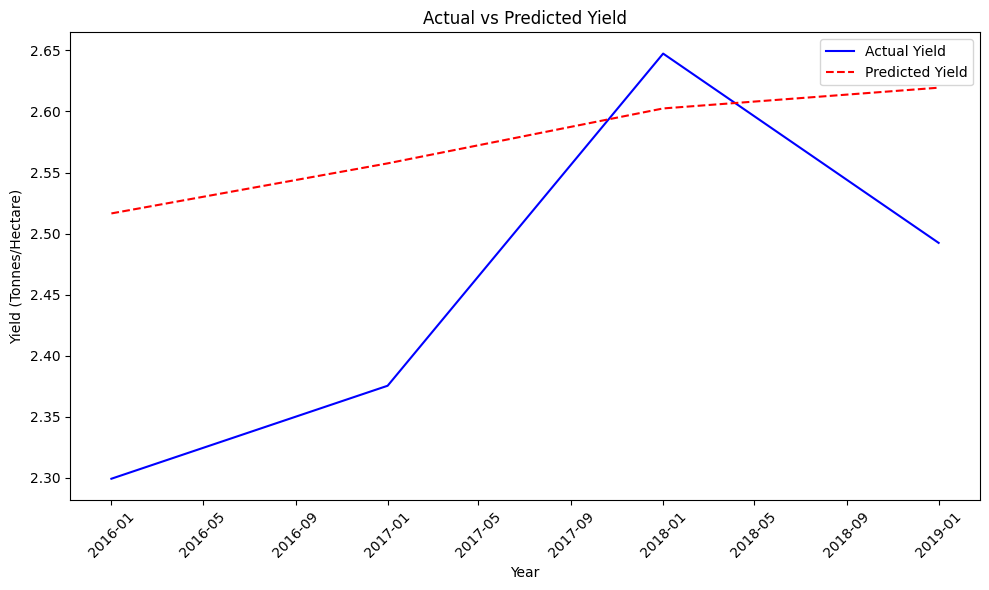

In [9]:
# Get the years corresponding to the test dataset
import matplotlib.pyplot as plt
test_years = rice_data.index[split_idx+seq_length:]

# Plot the results based on years
plt.figure(figsize=(10, 6))
plt.plot(test_years, y_test_inverse, color='blue', label='Actual Yield')
plt.plot(test_years, y_pred_inverse, color='red', linestyle='dashed', label='Predicted Yield')
plt.xlabel('Year')
plt.ylabel('Yield (Tonnes/Hectare)')
plt.title('Actual vs Predicted Yield')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [10]:
# Save the model
model.save('rice_yield_lstm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


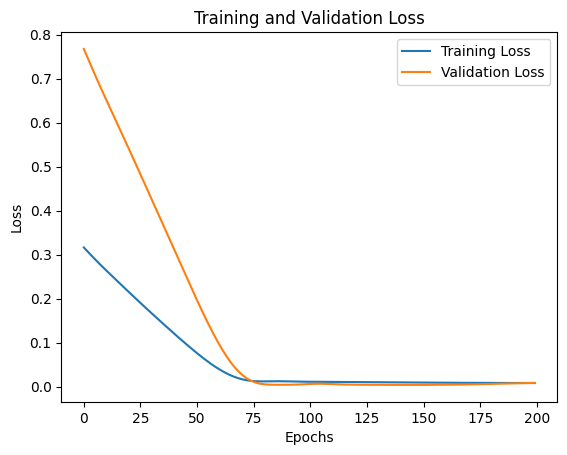

In [11]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Transfer Learning Nagaon Original

Epoch 1/8
1/1 [==============================] - 3s 3s/step - loss: 0.2641 - mean_absolute_error: 0.4981 - val_loss: 0.5604 - val_mean_absolute_error: 0.7406
Epoch 2/8
1/1 [==============================] - 0s 38ms/step - loss: 0.1979 - mean_absolute_error: 0.4271 - val_loss: 0.4276 - val_mean_absolute_error: 0.6455
Epoch 3/8
1/1 [==============================] - 0s 39ms/step - loss: 0.1479 - mean_absolute_error: 0.3646 - val_loss: 0.3124 - val_mean_absolute_error: 0.5496
Epoch 4/8
1/1 [==============================] - 0s 43ms/step - loss: 0.1047 - mean_absolute_error: 0.3001 - val_loss: 0.2153 - val_mean_absolute_error: 0.4531
Epoch 5/8
1/1 [==============================] - 0s 43ms/step - loss: 0.0701 - mean_absolute_error: 0.2360 - val_loss: 0.1386 - val_mean_absolute_error: 0.3586
Epoch 6/8
1/1 [==============================] - 0s 56ms/step - loss: 0.0444 - mean_absolute_error: 0.1736 - val_loss: 0.0811 - val_mean_absolute_error: 0.2661
Epoch 7/8
1/1 [===========================

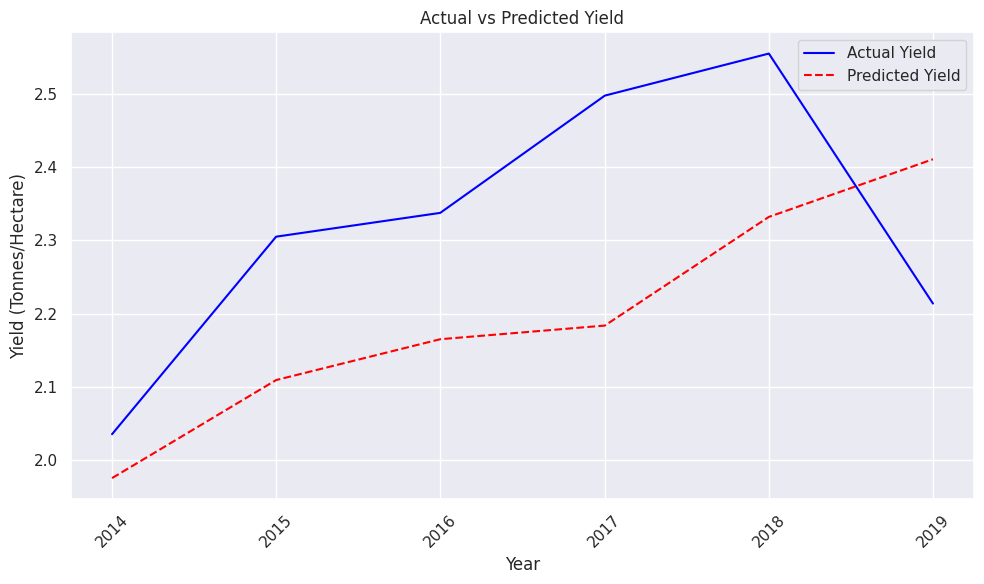

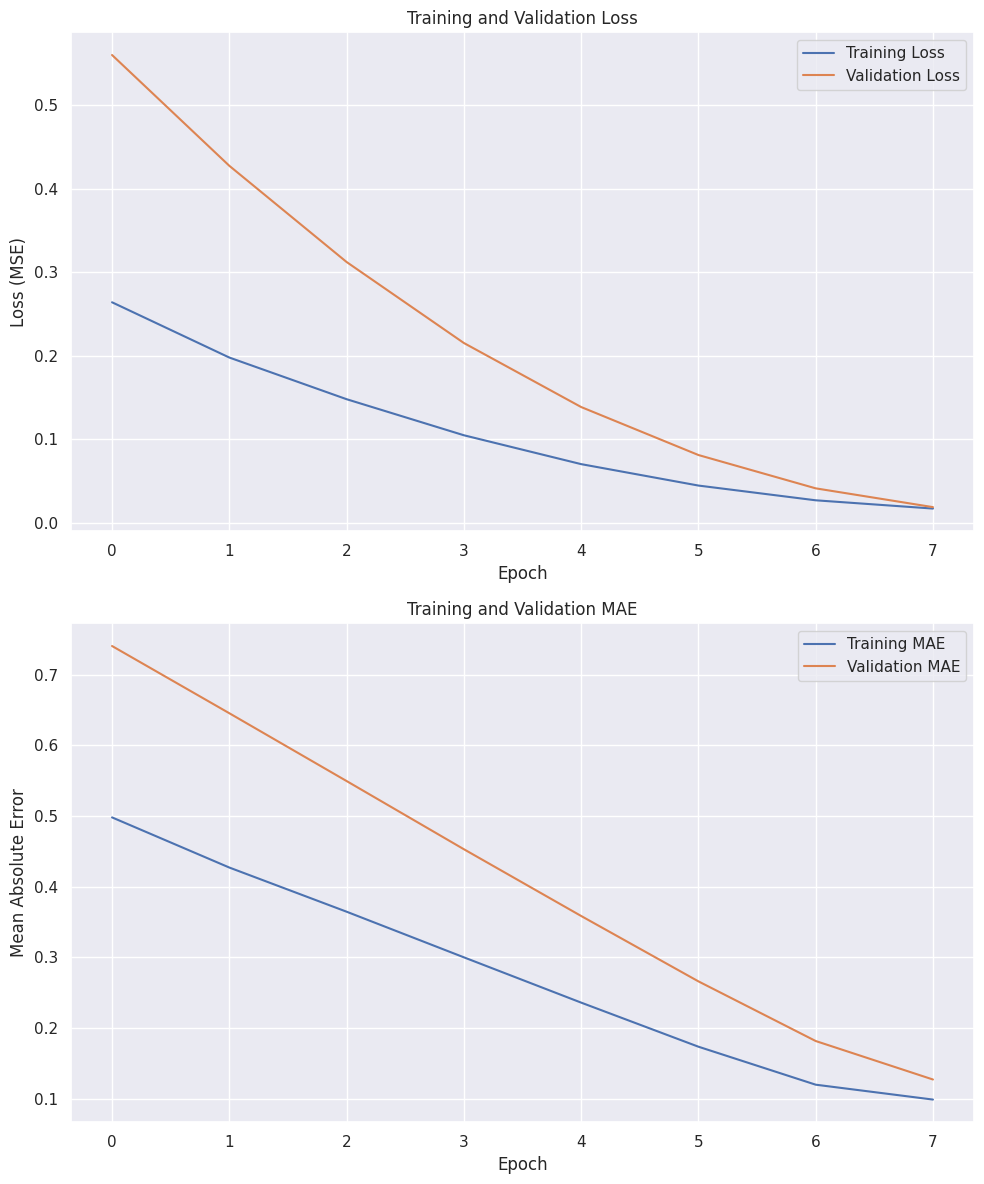

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model, Model
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.metrics import MeanAbsoluteError

# Load the saved model
saved_model_path = 'rice_yield_lstm_model.h5'
base_model = load_model(saved_model_path)

# Remove the output layer of the base model
base_model_output = base_model.layers[-2].output

# Create a new model by adding new layers on top of the base model (excluding the last layer)
x = Dense(200, activation='relu')(base_model_output)
x = Dense(200, activation='relu')(x)
output = Dense(1)(x)
model_2 = Model(inputs=base_model.input, outputs=output)

# Freeze all layers in the base model except the second-to-last layer
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Compile the new model with MAE metric
model_2.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError()])

# Load your new dataset
new_file_path = 'Nagaon_rice_cleaned_data.csv'  # Replace with your new dataset file path
new_data = pd.read_csv(new_file_path)

# Data Preprocessing
new_data['Year'] = pd.to_datetime(new_data['Year'])
new_data.set_index('Year', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
new_data['Yield (Tonnes/Hectare)'] = scaler.fit_transform(new_data[['Yield (Tonnes/Hectare)']])

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 3
data = new_data['Yield (Tonnes/Hectare)'].values
X, y = create_sequences(data, seq_length)

split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape the data
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the new model (fine-tuning)
history = model_2.fit(X_train_reshaped, y_train, epochs=8, validation_data=(X_test_reshaped, y_test), verbose=1)

# Make predictions
y_pred = model_2.predict(X_test_reshaped)

# Inverse transform the predictions and the true values
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute MAE on the test set
mae = np.mean(np.abs(y_test_inverse - y_pred_inverse))
print(f'Mean Absolute Error on the test set: {mae:.4f}')

# Plot the results based on years
test_years = new_data.index[split_idx+seq_length:]

plt.figure(figsize=(10, 6))
plt.plot(test_years, y_test_inverse, color='blue', label='Actual Yield')
plt.plot(test_years, y_pred_inverse, color='red', linestyle='dashed', label='Predicted Yield')
plt.xlabel('Year')
plt.ylabel('Yield (Tonnes/Hectare)')
plt.title('Actual vs Predicted Yield')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Plot training & validation loss and MAE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()

# MAE plot
ax2.plot(history.history['mean_absolute_error'], label='Training MAE')
ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
ax2.set_title('Training and Validation MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend()

plt.tight_layout()
plt.show()


In [ ]:
model_2.save('model_3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **Preprocessing**

In [ ]:
# load the data
raw_df = pd.read_excel("udaipur_rice.xls")
raw_df.to_csv('udaipur.csv', index=False)
raw_df

WARNING *** file size (16320) not 512 + multiple of sector size (512)


,Crop Production Statistics,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,NaN,NaN,NaN,NaN,NaN,NaN
1,State/Crop/District,Year,Season,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare)
2,Rajasthan,NaN,NaN,NaN,NaN,NaN
3,Rice,NaN,NaN,NaN,NaN,NaN
4,1.UDAIPUR,1997-98,Kharif,10200,8700,0.852941
5,NaN,1998-99,Kharif,8444,5257,0.622572
6,NaN,1999-00,Kharif,6452,2877,0.445908
7,NaN,2000-01,Kharif,5879,1663,0.282871
8,NaN,2001-02,Kharif,6272,7038,1.12213
9,NaN,2002-03,Kharif,3683,880,0.238936


In [ ]:
raw_df.columns = raw_df.iloc[1]
raw_df

1,State/Crop/District,Year,Season,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare)
0,NaN,NaN,NaN,NaN,NaN,NaN
1,State/Crop/District,Year,Season,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare)
2,Rajasthan,NaN,NaN,NaN,NaN,NaN
3,Rice,NaN,NaN,NaN,NaN,NaN
4,1.UDAIPUR,1997-98,Kharif,10200,8700,0.852941
5,NaN,1998-99,Kharif,8444,5257,0.622572
6,NaN,1999-00,Kharif,6452,2877,0.445908
7,NaN,2000-01,Kharif,5879,1663,0.282871
8,NaN,2001-02,Kharif,6272,7038,1.12213
9,NaN,2002-03,Kharif,3683,880,0.238936


In [ ]:
raw_df.dropna(subset=['Yield (Tonnes/Hectare)'], inplace=True)
raw_df

1,State/Crop/District,Year,Season,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare)
1,State/Crop/District,Year,Season,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare)
4,1.UDAIPUR,1997-98,Kharif,10200,8700,0.852941
5,NaN,1998-99,Kharif,8444,5257,0.622572
6,NaN,1999-00,Kharif,6452,2877,0.445908
7,NaN,2000-01,Kharif,5879,1663,0.282871
8,NaN,2001-02,Kharif,6272,7038,1.12213
9,NaN,2002-03,Kharif,3683,880,0.238936
10,NaN,2003-04,Kharif,5141,6070,1.180704
11,NaN,2004-05,Kharif,5564,4165,0.748562
12,NaN,2005-06,Kharif,5785,4477,0.773898


In [ ]:
df = raw_df.drop(index = 1)
df

1,State/Crop/District,Year,Season,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare)
4,1.UDAIPUR,1997-98,Kharif,10200,8700,0.852941
5,NaN,1998-99,Kharif,8444,5257,0.622572
6,NaN,1999-00,Kharif,6452,2877,0.445908
7,NaN,2000-01,Kharif,5879,1663,0.282871
8,NaN,2001-02,Kharif,6272,7038,1.12213
9,NaN,2002-03,Kharif,3683,880,0.238936
10,NaN,2003-04,Kharif,5141,6070,1.180704
11,NaN,2004-05,Kharif,5564,4165,0.748562
12,NaN,2005-06,Kharif,5785,4477,0.773898
13,NaN,2006-07,Kharif,6175,5725,0.927126


In [ ]:
df = df.drop(index = 27)
df

1,State/Crop/District,Year,Season,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare)
4,1.UDAIPUR,1997-98,Kharif,10200,8700,0.852941
5,NaN,1998-99,Kharif,8444,5257,0.622572
6,NaN,1999-00,Kharif,6452,2877,0.445908
7,NaN,2000-01,Kharif,5879,1663,0.282871
8,NaN,2001-02,Kharif,6272,7038,1.12213
9,NaN,2002-03,Kharif,3683,880,0.238936
10,NaN,2003-04,Kharif,5141,6070,1.180704
11,NaN,2004-05,Kharif,5564,4165,0.748562
12,NaN,2005-06,Kharif,5785,4477,0.773898
13,NaN,2006-07,Kharif,6175,5725,0.927126


In [ ]:
df['Year'] = df['Year'].fillna(method='ffill')
df

1,State/Crop/District,Year,Season,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare)
4,1.VILLUPURAM,1998-99,Kharif,156618,539236,3.443001
5,NaN,1999-00,Kharif,142737,488497,3.422357
6,NaN,2000-01,Kharif,141767,498417,3.515748
7,NaN,2001-02,Kharif,155555,561130,3.607277
8,NaN,2002-03,Kharif,80630,241287,2.992521
9,NaN,2003-04,Kharif,75279,234750,3.1184
10,NaN,2004-05,Kharif,163696,525850,3.212357
11,NaN,2005-06,Kharif,168435,511931,3.039339
12,NaN,2006-07,Kharif,144783,496113,3.426597
13,NaN,2007-08,Kharif,145403,480329,3.303433


In [ ]:
df = df.drop(index = 23)
df = df.drop(index = 24)
df = df.drop(index = 25)
df = df.drop(index = 27)
df = df.drop(index = 28)
df = df.drop(index = 29)
df = df.drop(index = 31)
df = df.drop(index = 32)
df = df.drop(index = 33)
df

1,State/Crop/District,Year,Season,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare)
4,1.VILLUPURAM,1998-99,Kharif,156618,539236,3.443001
5,NaN,1999-00,Kharif,142737,488497,3.422357
6,NaN,2000-01,Kharif,141767,498417,3.515748
7,NaN,2001-02,Kharif,155555,561130,3.607277
8,NaN,2002-03,Kharif,80630,241287,2.992521
9,NaN,2003-04,Kharif,75279,234750,3.1184
10,NaN,2004-05,Kharif,163696,525850,3.212357
11,NaN,2005-06,Kharif,168435,511931,3.039339
12,NaN,2006-07,Kharif,144783,496113,3.426597
13,NaN,2007-08,Kharif,145403,480329,3.303433


In [ ]:
newdf = df.reset_index()
newdf

1,index,State/Crop/District,Year,Season,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare)
0,4,1.UDAIPUR,1997-98,Kharif,10200,8700,0.852941
1,5,NaN,1998-99,Kharif,8444,5257,0.622572
2,6,NaN,1999-00,Kharif,6452,2877,0.445908
3,7,NaN,2000-01,Kharif,5879,1663,0.282871
4,8,NaN,2001-02,Kharif,6272,7038,1.12213
5,9,NaN,2002-03,Kharif,3683,880,0.238936
6,10,NaN,2003-04,Kharif,5141,6070,1.180704
7,11,NaN,2004-05,Kharif,5564,4165,0.748562
8,12,NaN,2005-06,Kharif,5785,4477,0.773898
9,13,NaN,2006-07,Kharif,6175,5725,0.927126


In [ ]:
df = newdf.drop(['index', 'Season', 'Area (Hectare)', 'Production (Tonnes)','State/Crop/District'], axis=1)  # df.columns is zero-based pd.Index
df

1,Year,Yield (Tonnes/Hectare)
0,1997-98,0.852941
1,1998-99,0.622572
2,1999-00,0.445908
3,2000-01,0.282871
4,2001-02,1.12213
5,2002-03,0.238936
6,2003-04,1.180704
7,2004-05,0.748562
8,2005-06,0.773898
9,2006-07,0.927126


In [ ]:
df['Year'] = (pd.to_datetime(df['Year'].str.split('-', expand=True)[0])).dt.year
df.set_index('Year', inplace=True)
df = df.astype('float32')

df

<ipython-input-132-e51455692f2a>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Year'] = (pd.to_datetime(df['Year'].str.split('-', expand=True)[0])).dt.year


1,Yield (Tonnes/Hectare)
Year,
1997,0.852941
1998,0.622572
1999,0.445908
2000,0.282871
2001,1.122130
2002,0.238936
2003,1.180704
2004,0.748562
2005,0.773898


In [ ]:
# preprocessing
raw_df.columns = raw_df.iloc[1]
raw_df.dropna(subset=['Yield (Tonnes/Hectare)'], inplace=True)
raw_df['Year'] = raw_df['Year'].fillna(method='ffill')
df = raw_df.drop(index = 1)
df = df.drop(index = 35)
filtered_df = df[df['Season'].str.contains('Total')]
newdf = filtered_df.reset_index()
df = newdf.drop(['index', 'Season', 'Area (Hectare)', 'Production (Tonnes)'], axis=1)  # df.columns is zero-based pd.Index
df['Year'] = (pd.to_datetime(df['Year'].str.split('-', expand=True)[0])).dt.year
df.set_index('Year', inplace=True)
df = df.astype('float32')
df = df.drop(['State/Crop/District'], axis = 1)
df

<ipython-input-77-03c743d1bb2b>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Year'] = (pd.to_datetime(df['Year'].str.split('-', expand=True)[0])).dt.year


1,Yield (Tonnes/Hectare)
Year,
2017,4.297967
2018,4.489400
2019,4.175825


<Axes: xlabel='Year'>

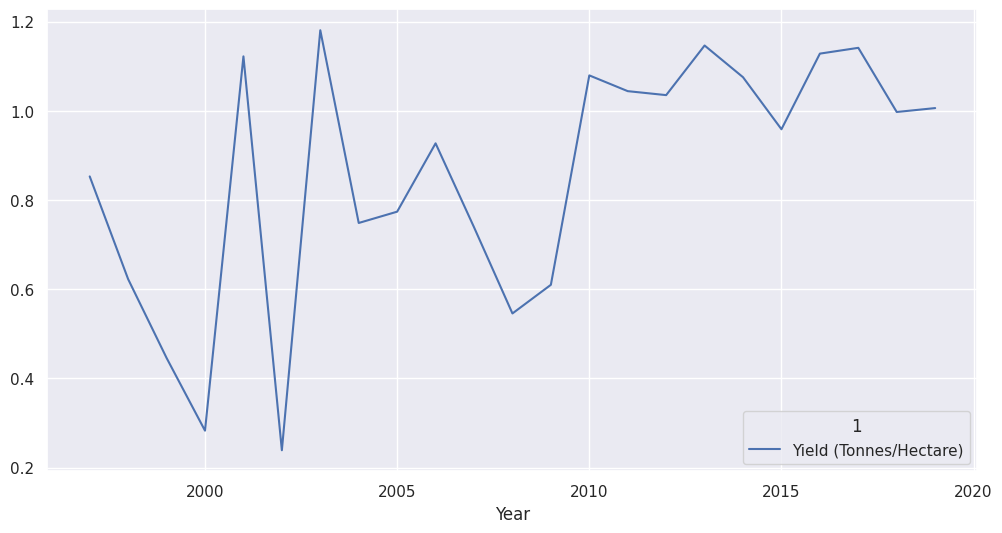

In [ ]:
df.plot(figsize=(12, 6))

In [ ]:
df.to_csv('udaipur_rice_cleaned_data.csv')

# Transfer Learnng for Marigaon

Epoch 1/8
1/1 [==============================] - 8s 8s/step - loss: 0.3164 - mean_absolute_error: 0.5107 - val_loss: 0.4898 - val_mean_absolute_error: 0.6993
Epoch 2/8
1/1 [==============================] - 0s 58ms/step - loss: 0.2462 - mean_absolute_error: 0.4411 - val_loss: 0.3504 - val_mean_absolute_error: 0.5913
Epoch 3/8
1/1 [==============================] - 0s 40ms/step - loss: 0.1873 - mean_absolute_error: 0.3733 - val_loss: 0.2370 - val_mean_absolute_error: 0.4860
Epoch 4/8
1/1 [==============================] - 0s 56ms/step - loss: 0.1401 - mean_absolute_error: 0.3091 - val_loss: 0.1492 - val_mean_absolute_error: 0.3851
Epoch 5/8
1/1 [==============================] - 0s 39ms/step - loss: 0.1033 - mean_absolute_error: 0.2530 - val_loss: 0.0831 - val_mean_absolute_error: 0.2865
Epoch 6/8
1/1 [==============================] - 0s 42ms/step - loss: 0.0755 - mean_absolute_error: 0.2067 - val_loss: 0.0383 - val_mean_absolute_error: 0.1925
Epoch 7/8
1/1 [===========================

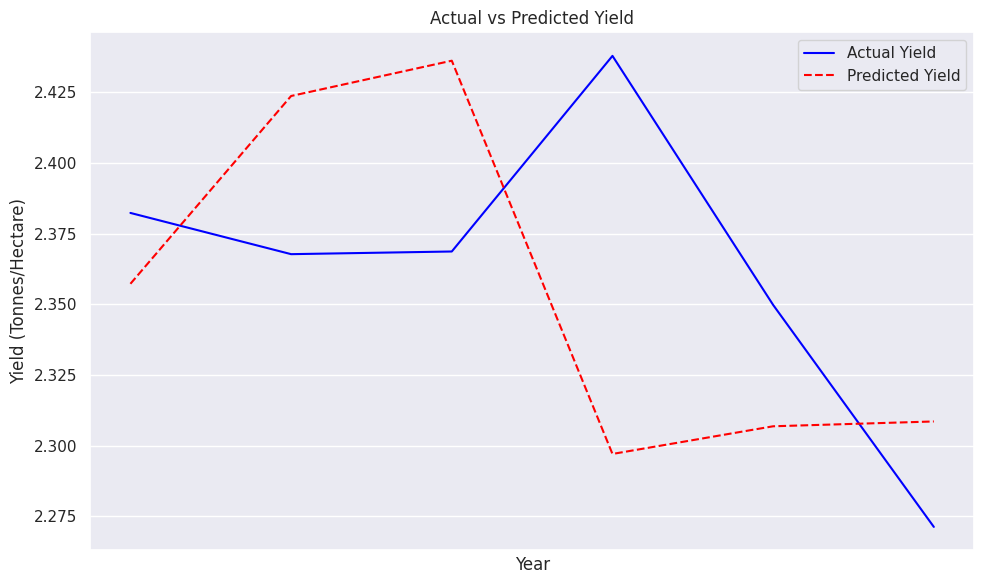

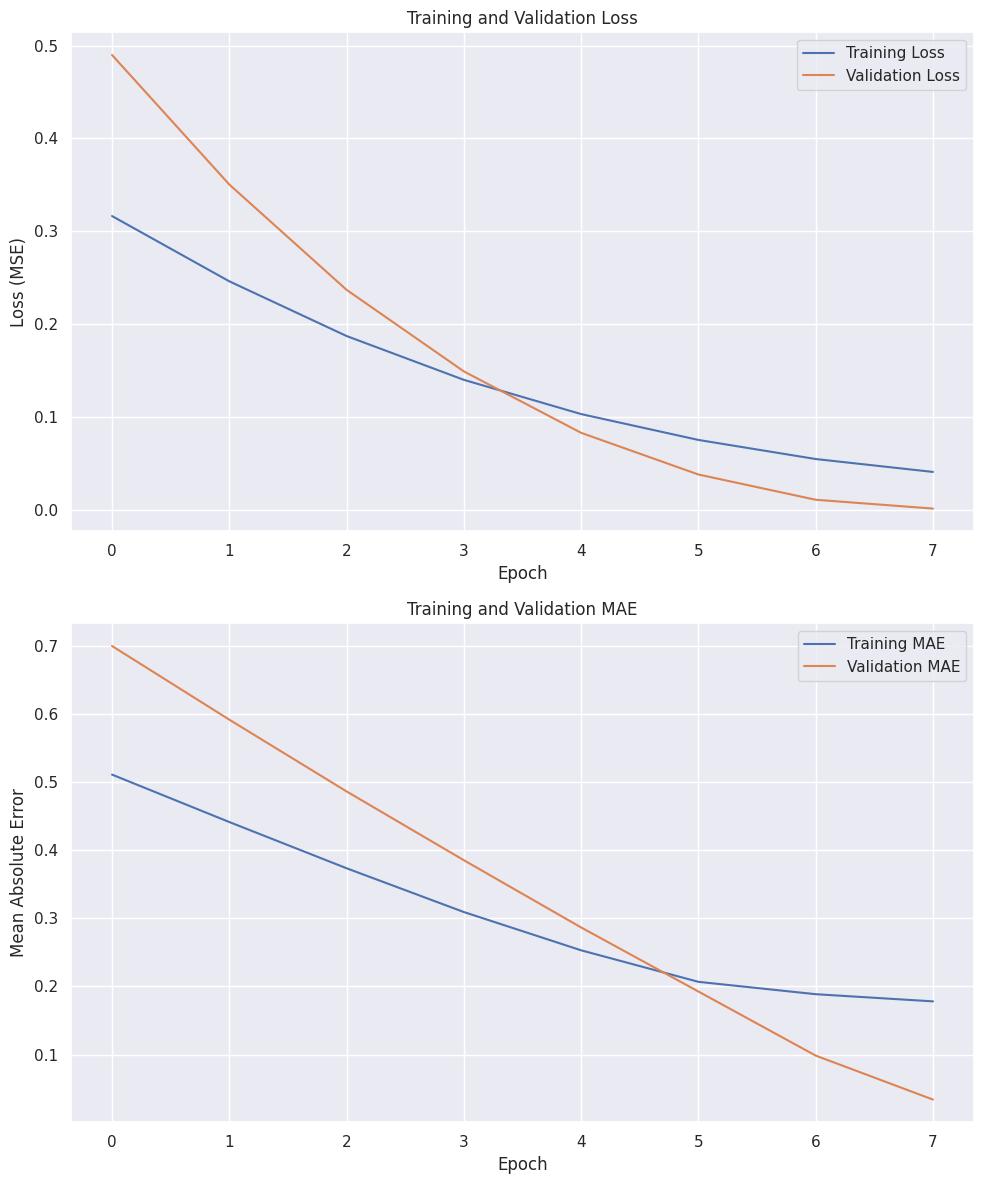

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model, Model
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.metrics import MeanAbsoluteError

# Load the saved model
saved_model_path = 'rice_yield_lstm_model.h5'
base_model = load_model(saved_model_path)

# Remove the output layer of the base model
base_model_output = base_model.layers[-2].output

# Create a new model by adding new layers on top of the base model (excluding the last layer)
x = Dense(200, activation='relu')(base_model_output)
x = Dense(200, activation='relu')(x)
output = Dense(1)(x)
model_2 = Model(inputs=base_model.input, outputs=output)

# Freeze all layers in the base model except the second-to-last layer
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Compile the new model with MAE metric
model_2.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError()])

# Load your new dataset
new_file_path = 'Marigaon_rice_cleaned_data.csv'  # Replace with your new dataset file path
new_data = pd.read_csv(new_file_path)

# Data Preprocessing
new_data['Year'] = pd.to_datetime(new_data['Year'])
new_data.set_index('Year', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
new_data['Yield (Tonnes/Hectare)'] = scaler.fit_transform(new_data[['Yield (Tonnes/Hectare)']])

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 3
data = new_data['Yield (Tonnes/Hectare)'].values
X, y = create_sequences(data, seq_length)

split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape the data
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the new model (fine-tuning)
history = model_2.fit(X_train_reshaped, y_train, epochs=8, validation_data=(X_test_reshaped, y_test), verbose=1)

# Make predictions
y_pred = model_2.predict(X_test_reshaped)

# Inverse transform the predictions and the true values
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute MAE on the test set
mae = np.mean(np.abs(y_test_inverse - y_pred_inverse))
print(f'Mean Absolute Error on the test set: {mae:.4f}')

# Plot the results based on years
test_years = new_data.index[split_idx+seq_length:]

plt.figure(figsize=(10, 6))
plt.plot(test_years, y_test_inverse, color='blue', label='Actual Yield')
plt.plot(test_years, y_pred_inverse, color='red', linestyle='dashed', label='Predicted Yield')
plt.xlabel('Year')
plt.ylabel('Yield (Tonnes/Hectare)')
plt.title('Actual vs Predicted Yield')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Plot training & validation loss and MAE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()

# MAE plot
ax2.plot(history.history['mean_absolute_error'], label='Training MAE')
ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
ax2.set_title('Training and Validation MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend()

plt.tight_layout()
plt.show()


# Transfer Learning for Jorhat


Epoch 1/8
1/1 [==============================] - 4s 4s/step - loss: 0.2377 - mean_absolute_error: 0.4534 - val_loss: 0.4977 - val_mean_absolute_error: 0.6938
Epoch 2/8
1/1 [==============================] - 0s 60ms/step - loss: 0.1783 - mean_absolute_error: 0.3841 - val_loss: 0.3770 - val_mean_absolute_error: 0.6018
Epoch 3/8
1/1 [==============================] - 0s 59ms/step - loss: 0.1334 - mean_absolute_error: 0.3307 - val_loss: 0.2786 - val_mean_absolute_error: 0.5149
Epoch 4/8
1/1 [==============================] - 0s 56ms/step - loss: 0.0980 - mean_absolute_error: 0.2796 - val_loss: 0.1948 - val_mean_absolute_error: 0.4272
Epoch 5/8
1/1 [==============================] - 0s 52ms/step - loss: 0.0697 - mean_absolute_error: 0.2306 - val_loss: 0.1258 - val_mean_absolute_error: 0.3386
Epoch 6/8
1/1 [==============================] - 0s 73ms/step - loss: 0.0485 - mean_absolute_error: 0.1854 - val_loss: 0.0715 - val_mean_absolute_error: 0.2477
Epoch 7/8
1/1 [===========================

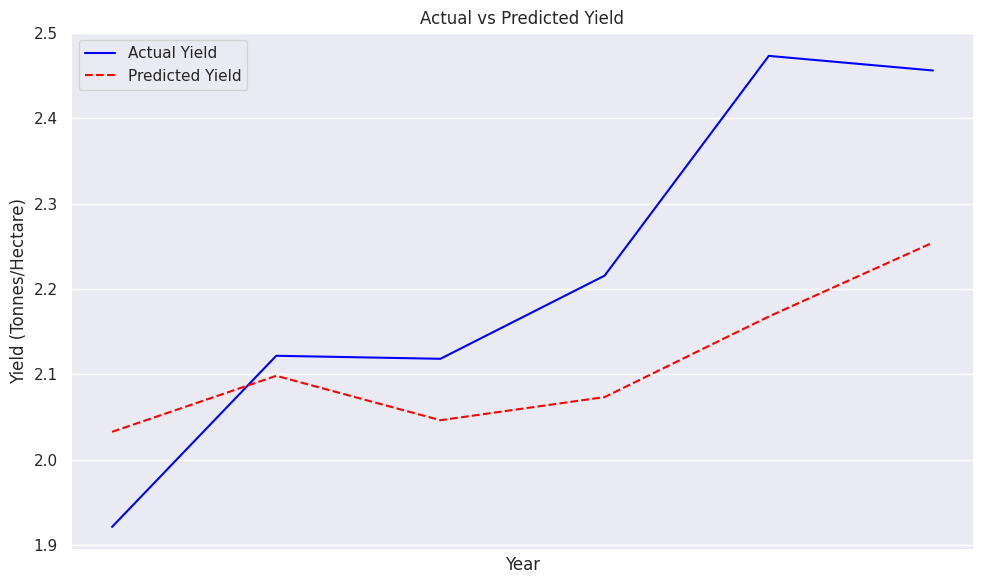

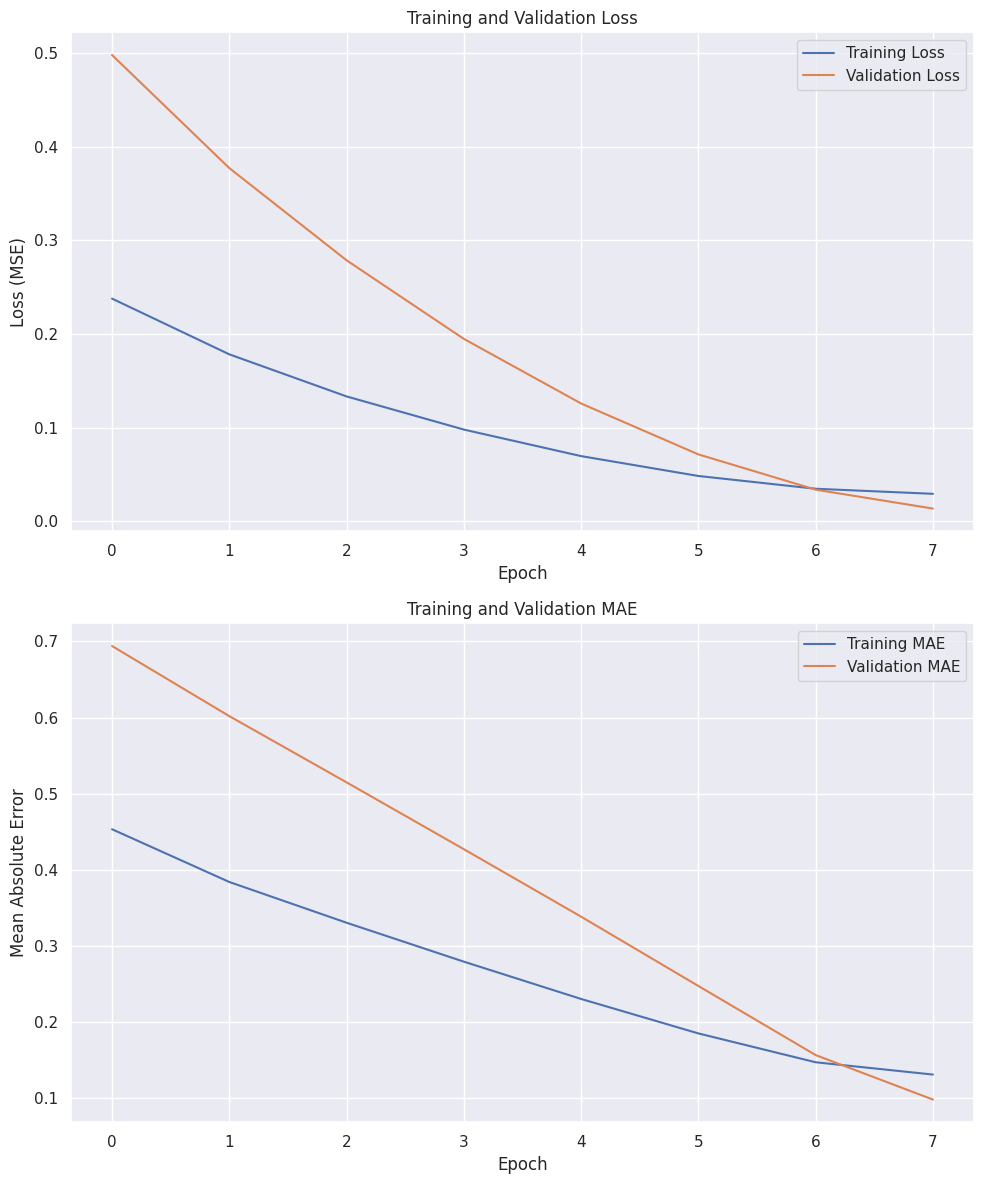

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model, Model
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.metrics import MeanAbsoluteError

# Load the saved model
saved_model_path = 'rice_yield_lstm_model.h5'
base_model = load_model(saved_model_path)

# Remove the output layer of the base model
base_model_output = base_model.layers[-2].output

# Create a new model by adding new layers on top of the base model (excluding the last layer)
x = Dense(200, activation='relu')(base_model_output)
x = Dense(200, activation='relu')(x)
output = Dense(1)(x)
model_2 = Model(inputs=base_model.input, outputs=output)

# Freeze all layers in the base model except the second-to-last layer
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Compile the new model with MAE metric
model_2.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError()])

# Load your new dataset
new_file_path = 'Jorhat_rice_cleaned_data.csv'  # Replace with your new dataset file path
new_data = pd.read_csv(new_file_path)

# Data Preprocessing
new_data['Year'] = pd.to_datetime(new_data['Year'])
new_data.set_index('Year', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
new_data['Yield (Tonnes/Hectare)'] = scaler.fit_transform(new_data[['Yield (Tonnes/Hectare)']])

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 3
data = new_data['Yield (Tonnes/Hectare)'].values
X, y = create_sequences(data, seq_length)

split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape the data
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the new model (fine-tuning)
history = model_2.fit(X_train_reshaped, y_train, epochs=8, validation_data=(X_test_reshaped, y_test), verbose=1)

# Make predictions
y_pred = model_2.predict(X_test_reshaped)

# Inverse transform the predictions and the true values
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute MAE on the test set
mae = np.mean(np.abs(y_test_inverse - y_pred_inverse))
print(f'Mean Absolute Error on the test set: {mae:.4f}')

# Plot the results based on years
test_years = new_data.index[split_idx+seq_length:]

plt.figure(figsize=(10, 6))
plt.plot(test_years, y_test_inverse, color='blue', label='Actual Yield')
plt.plot(test_years, y_pred_inverse, color='red', linestyle='dashed', label='Predicted Yield')
plt.xlabel('Year')
plt.ylabel('Yield (Tonnes/Hectare)')
plt.title('Actual vs Predicted Yield')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Plot training & validation loss and MAE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()

# MAE plot
ax2.plot(history.history['mean_absolute_error'], label='Training MAE')
ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
ax2.set_title('Training and Validation MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend()

plt.tight_layout()
plt.show()


# Transfer learning for Bongaigaon district

Epoch 1/8
1/1 [==============================] - 4s 4s/step - loss: 0.1998 - mean_absolute_error: 0.3948 - val_loss: 0.4464 - val_mean_absolute_error: 0.6504
Epoch 2/8
1/1 [==============================] - 0s 59ms/step - loss: 0.1574 - mean_absolute_error: 0.3421 - val_loss: 0.3316 - val_mean_absolute_error: 0.5549
Epoch 3/8
1/1 [==============================] - 0s 57ms/step - loss: 0.1222 - mean_absolute_error: 0.2913 - val_loss: 0.2348 - val_mean_absolute_error: 0.4589
Epoch 4/8
1/1 [==============================] - 0s 39ms/step - loss: 0.0926 - mean_absolute_error: 0.2409 - val_loss: 0.1578 - val_mean_absolute_error: 0.3645
Epoch 5/8
1/1 [==============================] - 0s 40ms/step - loss: 0.0680 - mean_absolute_error: 0.1941 - val_loss: 0.0968 - val_mean_absolute_error: 0.2666
Epoch 6/8
1/1 [==============================] - 0s 57ms/step - loss: 0.0483 - mean_absolute_error: 0.1510 - val_loss: 0.0542 - val_mean_absolute_error: 0.1907
Epoch 7/8
1/1 [===========================

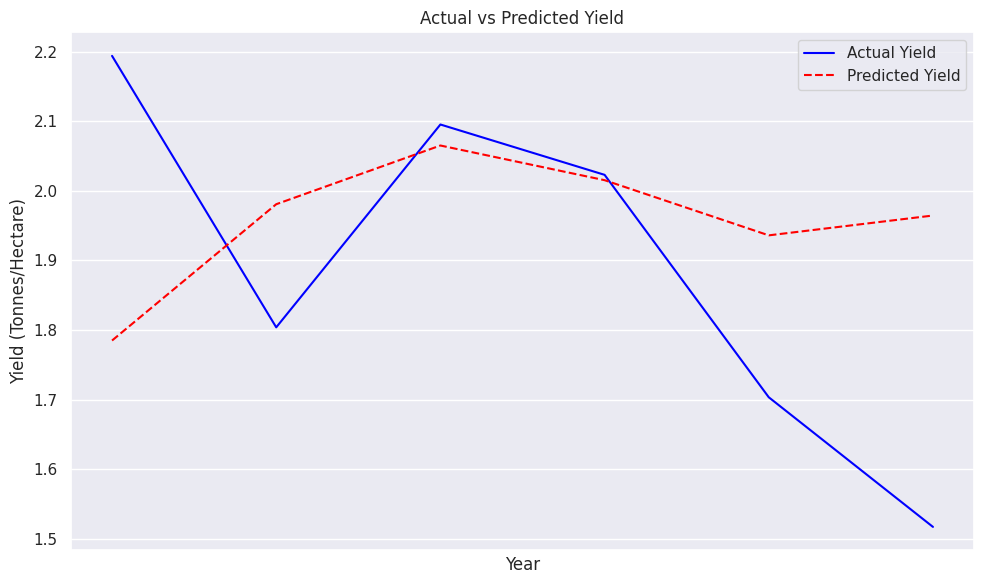

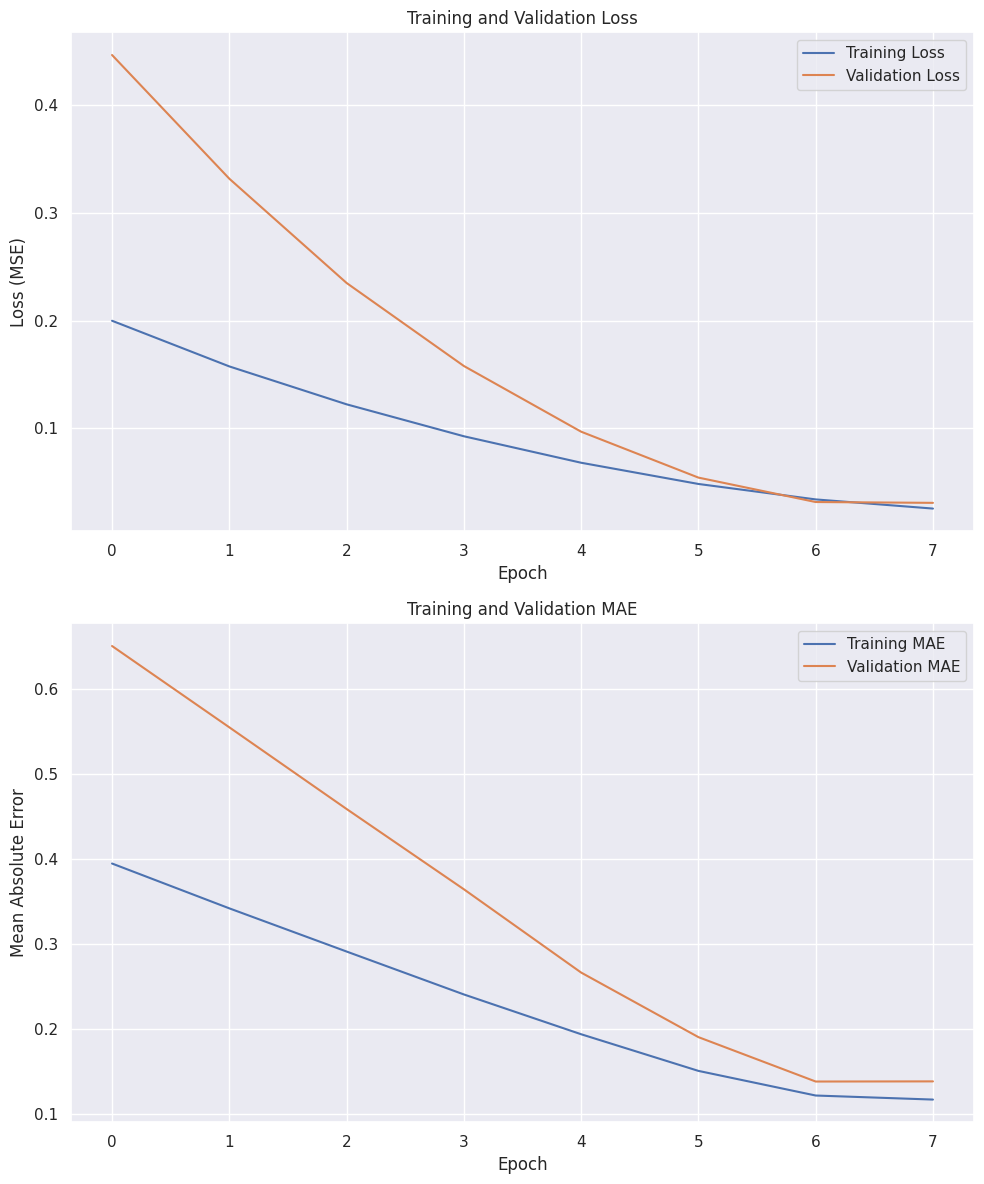

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model, Model
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.metrics import MeanAbsoluteError

# Load the saved model
saved_model_path = 'rice_yield_lstm_model.h5'
base_model = load_model(saved_model_path)

# Remove the output layer of the base model
base_model_output = base_model.layers[-2].output

# Create a new model by adding new layers on top of the base model (excluding the last layer)
x = Dense(200, activation='relu')(base_model_output)
x = Dense(200, activation='relu')(x)
output = Dense(1)(x)
model_2 = Model(inputs=base_model.input, outputs=output)

# Freeze all layers in the base model except the second-to-last layer
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Compile the new model with MAE metric
model_2.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError()])

# Load your new dataset
new_file_path = 'Bongaigaon_rice_cleaned_data.csv'  # Replace with your new dataset file path
new_data = pd.read_csv(new_file_path)

# Data Preprocessing
new_data['Year'] = pd.to_datetime(new_data['Year'])
new_data.set_index('Year', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
new_data['Yield (Tonnes/Hectare)'] = scaler.fit_transform(new_data[['Yield (Tonnes/Hectare)']])

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 3
data = new_data['Yield (Tonnes/Hectare)'].values
X, y = create_sequences(data, seq_length)

split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape the data
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the new model (fine-tuning)
history = model_2.fit(X_train_reshaped, y_train, epochs=8, validation_data=(X_test_reshaped, y_test), verbose=1)

# Make predictions
y_pred = model_2.predict(X_test_reshaped)

# Inverse transform the predictions and the true values
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute MAE on the test set
mae = np.mean(np.abs(y_test_inverse - y_pred_inverse))
print(f'Mean Absolute Error on the test set: {mae:.4f}')

# Plot the results based on years
test_years = new_data.index[split_idx+seq_length:]

plt.figure(figsize=(10, 6))
plt.plot(test_years, y_test_inverse, color='blue', label='Actual Yield')
plt.plot(test_years, y_pred_inverse, color='red', linestyle='dashed', label='Predicted Yield')
plt.xlabel('Year')
plt.ylabel('Yield (Tonnes/Hectare)')
plt.title('Actual vs Predicted Yield')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Plot training & validation loss and MAE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()

# MAE plot
ax2.plot(history.history['mean_absolute_error'], label='Training MAE')
ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
ax2.set_title('Training and Validation MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend()

plt.tight_layout()
plt.show()

# Transfer Learning for Darrang

Epoch 1/8
1/1 [==============================] - 6s 6s/step - loss: 0.2586 - mean_absolute_error: 0.4629 - val_loss: 0.5524 - val_mean_absolute_error: 0.7381
Epoch 2/8
1/1 [==============================] - 0s 60ms/step - loss: 0.2005 - mean_absolute_error: 0.4022 - val_loss: 0.4075 - val_mean_absolute_error: 0.6322
Epoch 3/8
1/1 [==============================] - 0s 40ms/step - loss: 0.1515 - mean_absolute_error: 0.3439 - val_loss: 0.2872 - val_mean_absolute_error: 0.5281
Epoch 4/8
1/1 [==============================] - 0s 44ms/step - loss: 0.1102 - mean_absolute_error: 0.2856 - val_loss: 0.1882 - val_mean_absolute_error: 0.4238
Epoch 5/8
1/1 [==============================] - 0s 60ms/step - loss: 0.0760 - mean_absolute_error: 0.2325 - val_loss: 0.1095 - val_mean_absolute_error: 0.3170
Epoch 6/8
1/1 [==============================] - 0s 40ms/step - loss: 0.0486 - mean_absolute_error: 0.1808 - val_loss: 0.0538 - val_mean_absolute_error: 0.2109
Epoch 7/8
1/1 [===========================

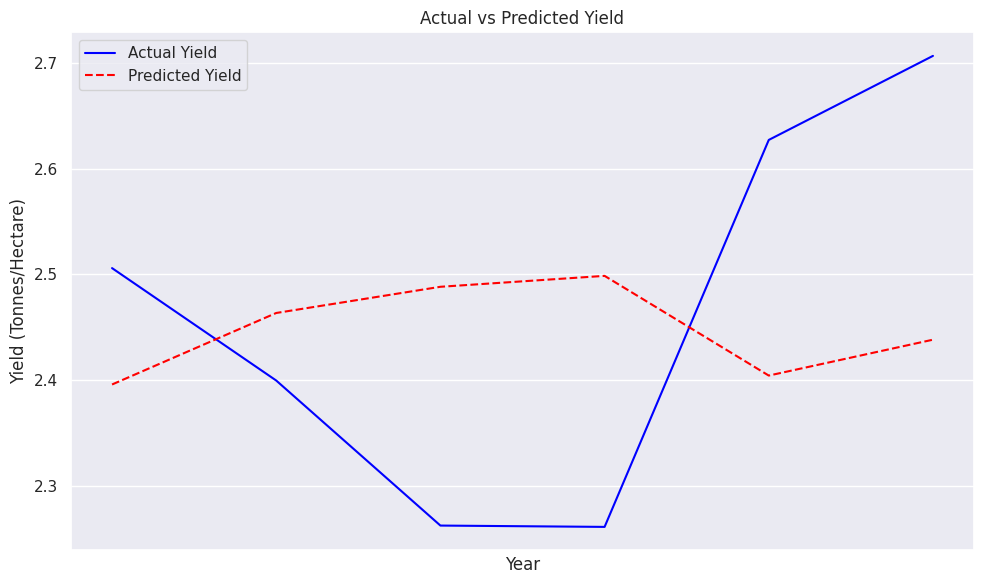

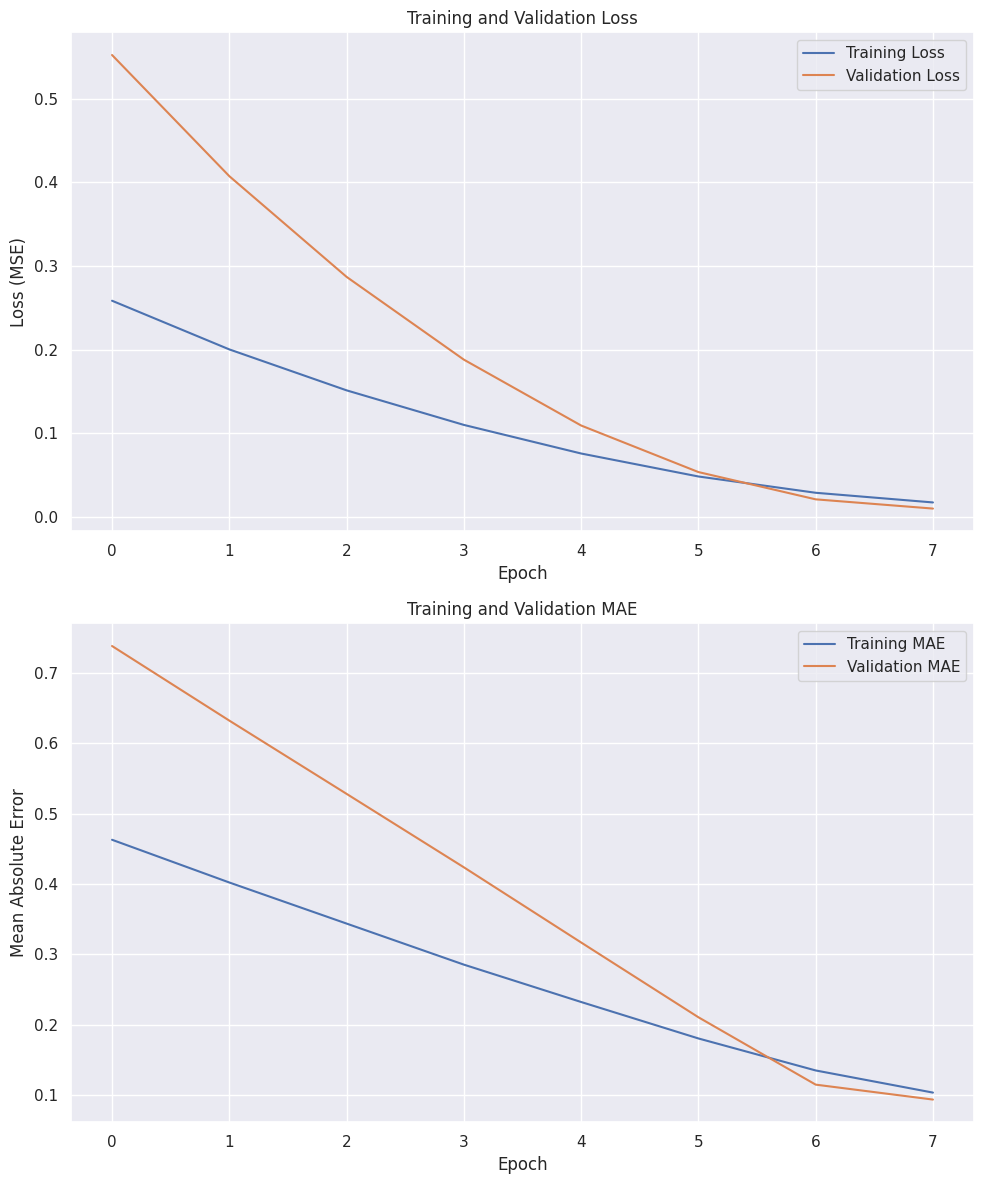

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model, Model
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.metrics import MeanAbsoluteError

# Load the saved model
saved_model_path = 'rice_yield_lstm_model.h5'
base_model = load_model(saved_model_path)

# Remove the output layer of the base model
base_model_output = base_model.layers[-2].output

# Create a new model by adding new layers on top of the base model (excluding the last layer)
x = Dense(200, activation='relu')(base_model_output)
x = Dense(200, activation='relu')(x)
output = Dense(1)(x)
model_2 = Model(inputs=base_model.input, outputs=output)

# Freeze all layers in the base model except the second-to-last layer
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Compile the new model with MAE metric
model_2.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError()])

# Load your new dataset
new_file_path = 'Darrang_rice_cleaned_data.csv'  # Replace with your new dataset file path
new_data = pd.read_csv(new_file_path)

# Data Preprocessing
new_data['Year'] = pd.to_datetime(new_data['Year'])
new_data.set_index('Year', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
new_data['Yield (Tonnes/Hectare)'] = scaler.fit_transform(new_data[['Yield (Tonnes/Hectare)']])

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 3
data = new_data['Yield (Tonnes/Hectare)'].values
X, y = create_sequences(data, seq_length)

split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape the data
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the new model (fine-tuning)
history = model_2.fit(X_train_reshaped, y_train, epochs=8, validation_data=(X_test_reshaped, y_test), verbose=1)

# Make predictions
y_pred = model_2.predict(X_test_reshaped)

# Inverse transform the predictions and the true values
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute MAE on the test set
mae = np.mean(np.abs(y_test_inverse - y_pred_inverse))
print(f'Mean Absolute Error on the test set: {mae:.4f}')

# Plot the results based on years
test_years = new_data.index[split_idx+seq_length:]

plt.figure(figsize=(10, 6))
plt.plot(test_years, y_test_inverse, color='blue', label='Actual Yield')
plt.plot(test_years, y_pred_inverse, color='red', linestyle='dashed', label='Predicted Yield')
plt.xlabel('Year')
plt.ylabel('Yield (Tonnes/Hectare)')
plt.title('Actual vs Predicted Yield')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Plot training & validation loss and MAE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()

# MAE plot
ax2.plot(history.history['mean_absolute_error'], label='Training MAE')
ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
ax2.set_title('Training and Validation MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend()

plt.tight_layout()
plt.show()

# Transfer Learning for Villupuram

Epoch 1/4
1/1 [==============================] - 6s 6s/step - loss: 0.1880 - mean_absolute_error: 0.3163 - val_loss: 0.3215 - val_mean_absolute_error: 0.5622
Epoch 2/4
1/1 [==============================] - 0s 43ms/step - loss: 0.1241 - mean_absolute_error: 0.2333 - val_loss: 0.1703 - val_mean_absolute_error: 0.4048
Epoch 3/4
1/1 [==============================] - 0s 43ms/step - loss: 0.0866 - mean_absolute_error: 0.1935 - val_loss: 0.0716 - val_mean_absolute_error: 0.2526
Epoch 4/4
1/1 [==============================] - 0s 201ms/step
Mean Absolute Error on the test set: 0.2144


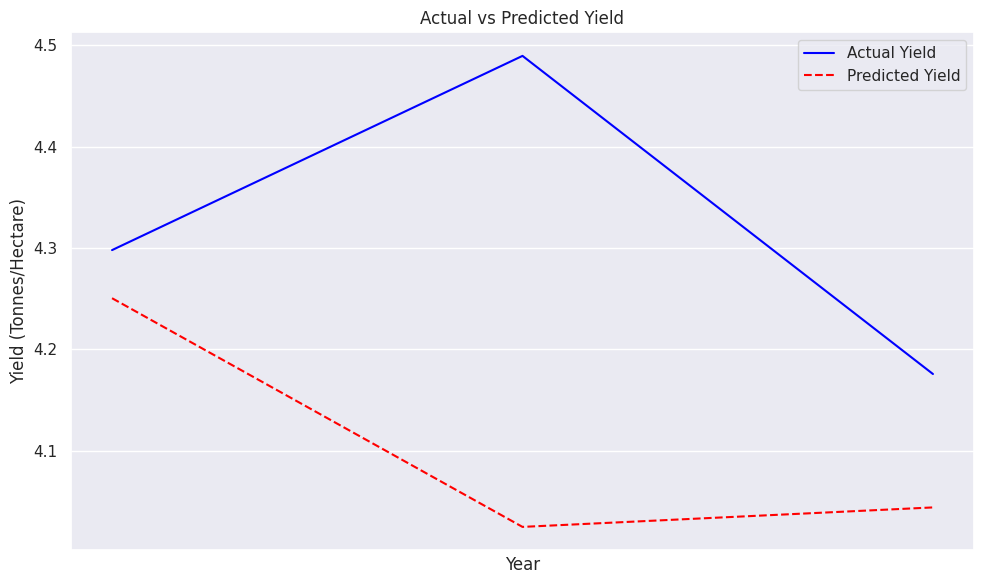

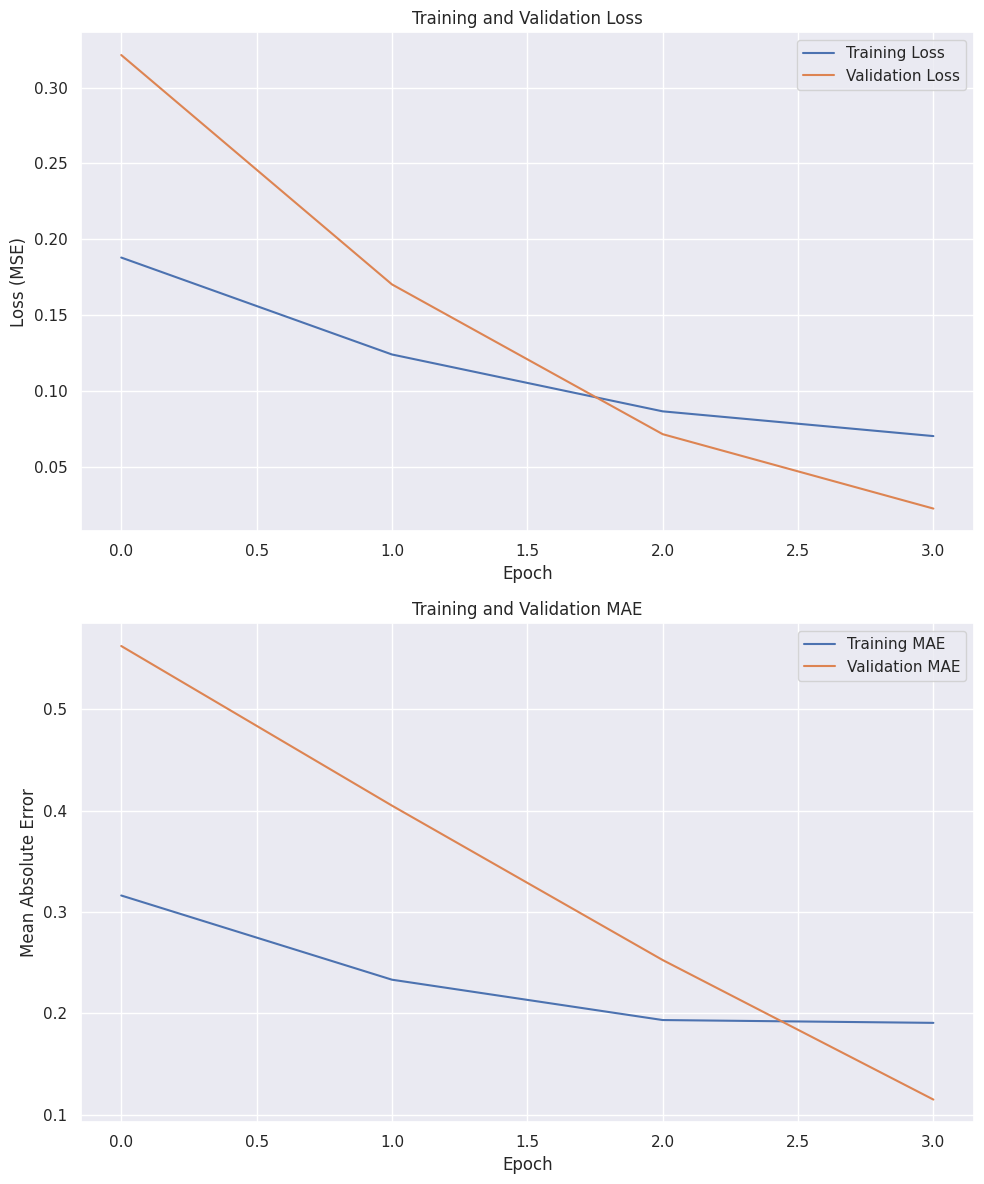

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model, Model
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.metrics import MeanAbsoluteError

# Load the saved model
saved_model_path = 'rice_yield_lstm_model.h5'
base_model = load_model(saved_model_path)

# Remove the output layer of the base model
base_model_output = base_model.layers[-2].output

# Create a new model by adding new layers on top of the base model (excluding the last layer)
x = Dense(500, activation='relu')(base_model_output)
x = Dense(500, activation='relu')(x)

output = Dense(1)(x)
model_2 = Model(inputs=base_model.input, outputs=output)

# Freeze all layers in the base model except the second-to-last layer
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Compile the new model with MAE metric
model_2.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError()])

# Load your new dataset
new_file_path = 'Villupuram_rice_cleaned_data.csv'  # Replace with your new dataset file path
new_data = pd.read_csv(new_file_path)

# Data Preprocessing
new_data['Year'] = pd.to_datetime(new_data['Year'])
new_data.set_index('Year', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
new_data['Yield (Tonnes/Hectare)'] = scaler.fit_transform(new_data[['Yield (Tonnes/Hectare)']])

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 3
data = new_data['Yield (Tonnes/Hectare)'].values
X, y = create_sequences(data, seq_length)

split_idx = int(0.85 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape the data
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the new model (fine-tuning)
history = model_2.fit(X_train_reshaped, y_train, epochs = 4, validation_data=(X_test_reshaped, y_test), verbose=1)

# Make predictions
y_pred = model_2.predict(X_test_reshaped)

# Inverse transform the predictions and the true values
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute MAE on the test set
mae = np.mean(np.abs(y_test_inverse - y_pred_inverse))
print(f'Mean Absolute Error on the test set: {mae:.4f}')

# Plot the results based on years
test_years = new_data.index[split_idx+seq_length:]

plt.figure(figsize=(10, 6))
plt.plot(test_years, y_test_inverse, color='blue', label='Actual Yield')
plt.plot(test_years, y_pred_inverse, color='red', linestyle='dashed', label='Predicted Yield')
plt.xlabel('Year')
plt.ylabel('Yield (Tonnes/Hectare)')
plt.title('Actual vs Predicted Yield')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Plot training & validation loss and MAE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()

# MAE plot
ax2.plot(history.history['mean_absolute_error'], label='Training MAE')
ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
ax2.set_title('Training and Validation MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend()

plt.tight_layout()
plt.show()

# Transfer Learning for Udaipur

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.5362 - mean_absolute_error: 0.6585 - val_loss: 0.6741 - val_mean_absolute_error: 0.8178
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.4430 - mean_absolute_error: 0.5885 - val_loss: 0.5190 - val_mean_absolute_error: 0.7166
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3648 - mean_absolute_error: 0.5325 - val_loss: 0.3878 - val_mean_absolute_error: 0.6182
Epoch 4/10
1/1 [==============================] - 0s 43ms/step - loss: 0.2998 - mean_absolute_error: 0.4815 - val_loss: 0.2769 - val_mean_absolute_error: 0.5207
Epoch 5/10
1/1 [==============================] - 0s 41ms/step - loss: 0.2461 - mean_absolute_error: 0.4320 - val_loss: 0.1902 - val_mean_absolute_error: 0.4292
Epoch 6/10
1/1 [==============================] - 0s 40ms/step - loss: 0.2048 - mean_absolute_error: 0.3871 - val_loss: 0.1239 - val_mean_absolute_error: 0.3432
Epoch 7/10
1/1 [====================

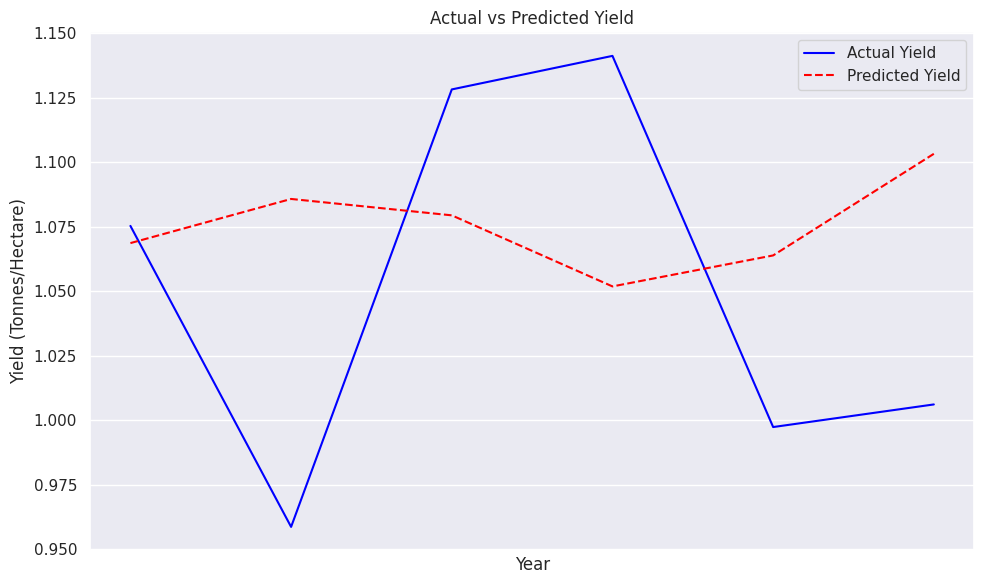

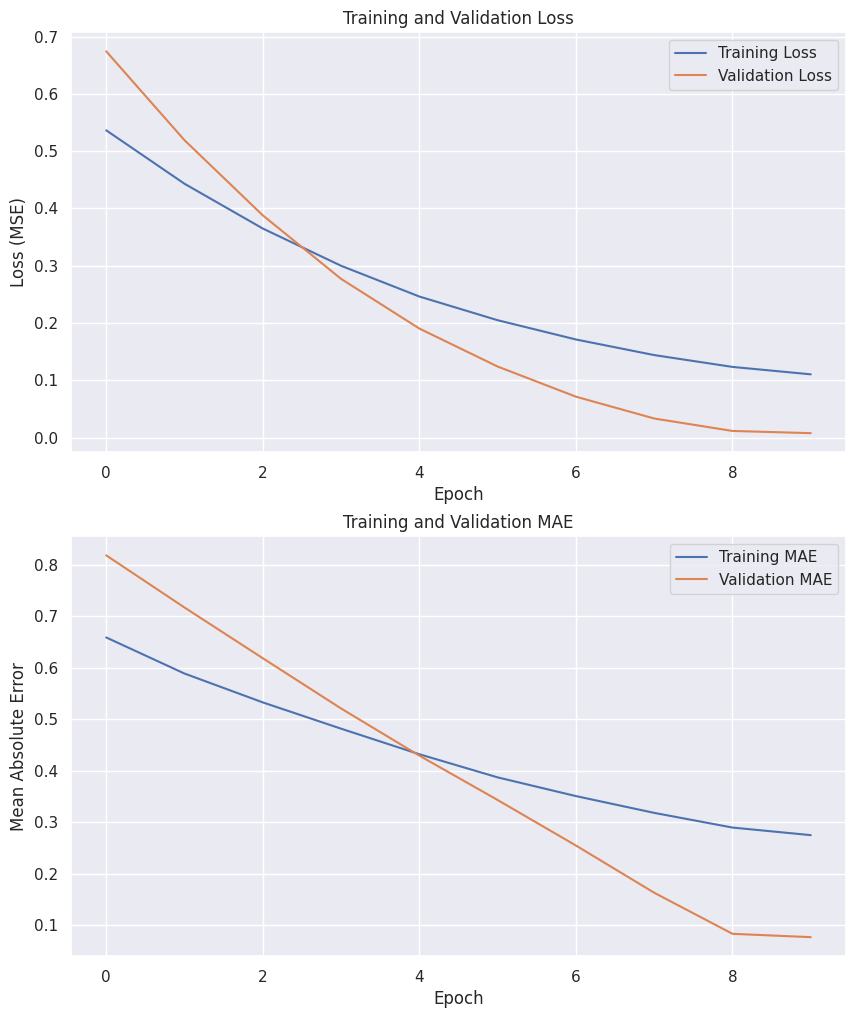

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model, Model
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.metrics import MeanAbsoluteError

# Load the saved model
saved_model_path = 'rice_yield_lstm_model.h5'
base_model = load_model(saved_model_path)

# Remove the output layer of the base model
base_model_output = base_model.layers[-2].output

# Create a new model by adding new layers on top of the base model (excluding the last layer)
x = Dense(200, activation='relu')(base_model_output)
x = Dense(200, activation='relu')(x)

output = Dense(1)(x)
model_2 = Model(inputs=base_model.input, outputs=output)

# Freeze all layers in the base model except the second-to-last layer
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Compile the new model with MAE metric
model_2.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError()])

# Load your new dataset
new_file_path = 'udaipur_rice_cleaned_data.csv'  # Replace with your new dataset file path
new_data = pd.read_csv(new_file_path)

# Data Preprocessing
new_data['Year'] = pd.to_datetime(new_data['Year'])
new_data.set_index('Year', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
new_data['Yield (Tonnes/Hectare)'] = scaler.fit_transform(new_data[['Yield (Tonnes/Hectare)']])

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 3
data = new_data['Yield (Tonnes/Hectare)'].values
X, y = create_sequences(data, seq_length)

split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape the data
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the new model (fine-tuning)
history = model_2.fit(X_train_reshaped, y_train, epochs = 10, validation_data=(X_test_reshaped, y_test), verbose=1)

# Make predictions
y_pred = model_2.predict(X_test_reshaped)

# Inverse transform the predictions and the true values
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute MAE on the test set
mae = np.mean(np.abs(y_test_inverse - y_pred_inverse))
print(f'Mean Absolute Error on the test set: {mae:.4f}')

# Plot the results based on years
test_years = new_data.index[split_idx+seq_length:]

plt.figure(figsize=(10, 6))
plt.plot(test_years, y_test_inverse, color='blue', label='Actual Yield')
plt.plot(test_years, y_pred_inverse, color='red', linestyle='dashed', label='Predicted Yield')
plt.xlabel('Year')
plt.ylabel('Yield (Tonnes/Hectare)')
plt.title('Actual vs Predicted Yield')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Plot training & validation loss and MAE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()

# MAE plot
ax2.plot(history.history['mean_absolute_error'], label='Training MAE')
ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
ax2.set_title('Training and Validation MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend()

# plt.tight_layout()
plt.show()